# Setup

In [1]:
import cupy as cp
import numpy as np

if cp.cuda.is_available():
	print("GPU is available")
	print("GPU: ", cp.cuda.runtime.getDeviceProperties(0)['name'])
import os
import tempfile
from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

MAKE_ANIMATIONS = True


tempdir = tempfile.TemporaryDirectory()

def make_video_from_solution(
	solution,
	quantities=("order_parameter", "phase"),
	fps=30,
	figsize=(5, 4),
	cmap=None,
	vmin_a=None,
	vmax_a=None,
	cmap_b=None,
	):
	"""Generates an HTML5 video from a tdgl.Solution."""
	with tdgl.non_gui_backend():
		with h5py.File(solution.path, "r") as h5file:
			print(cmap_b)
			anim = create_animation(
				h5file,
				quantities=quantities,
				fps=fps,
				figure_kwargs=dict(figsize=figsize, dpi=100),
				vmin=vmin_a,
				vmax=vmax_a,
				cmap_a=cmap_b,
			)
			video = anim.to_html5_video()
		return HTML(video)
	

	

GPU is available
GPU:  b'NVIDIA GeForce RTX 4070 SUPER'


C:\Users\cordo\AppData\Roaming\Python\Python310\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Physical properties

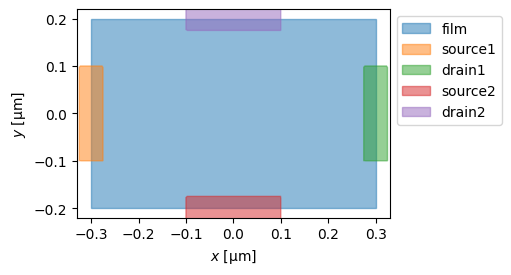

In [4]:
length_units = "um"
# Material parameters
xi = 0.1
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

width = 0.6
height = 0.4

film = tdgl.Polygon('film', points=box(width, height)).resample(401).buffer(0)


source1 = tdgl.Polygon('source1', points=box(0.05,0.2)).translate(-width/2, 0 ).buffer(0)
drain1 = tdgl.Polygon('drain1', points=box(0.05,0.2)).translate(width/2, 0 ).buffer(0)
source2 = tdgl.Polygon('source2', points=box(0.2,0.05)).translate(0,-height/2 ).buffer(0)
drain2 = tdgl.Polygon('drain2', points=box(0.2,0.05)).translate(0,height/2).buffer(0)


device=tdgl.Device("2currents",
				   layer=layer 
				   ,film=film
				   ,terminals= [source1,drain1,source2,drain2]
				   ,length_units=length_units
				   )

fig,ax=device.draw()

Constructing Voronoi polygons: 100%|██████████| 2217/2217 [00:01<00:00, 1688.15it/s]


min_edge_length: 2.903e-03
max_edge_length: 2.393e-02
mean_edge_length: 1.070e-02
min_area: 5.658e-06
max_area: 3.600e-04
mean_area: 1.083e-04
coherence_length: 1.000e-01


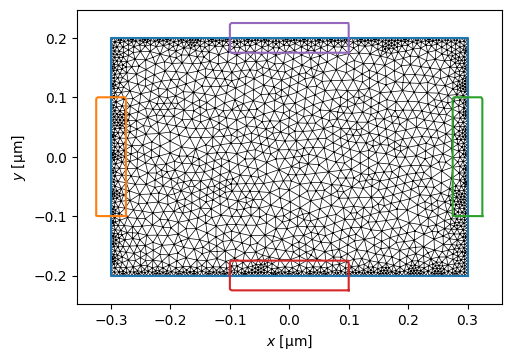

In [5]:
device.make_mesh(max_edge_length=xi / 4, smooth=100)
device.mesh_stats(print_b=True)
fig, ax = device.plot(mesh=True, legend=False)

The terminal currents are non-null, but the device has no probe points.
Simulating: 100%|█████████▉| 300/300 [01:12<00:00,  4.16tau/s ]


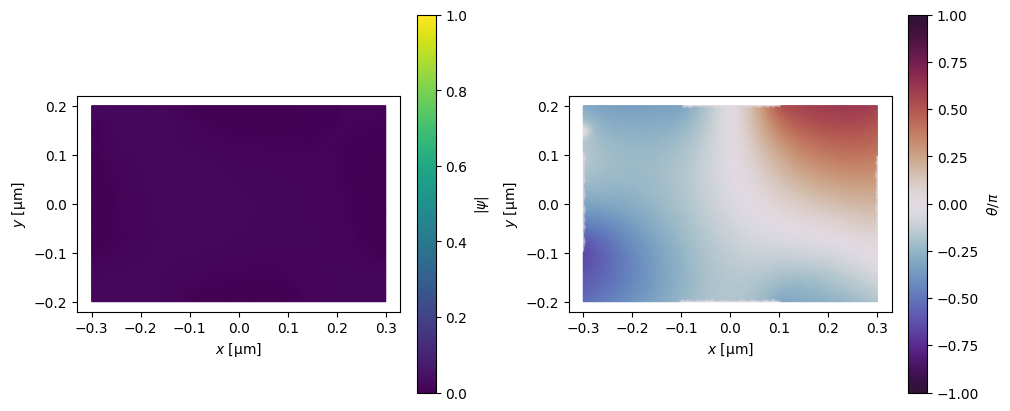

In [6]:


import tdgl.sources


options = tdgl.SolverOptions(
    solve_time=300,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",

)
applied_vector_potential=tdgl.sources.constant.ConstantField(15,field_units=options.field_units,length_units=device.length_units)
zero_current_solution = tdgl.solve(
	device=device,
	options=options,
	applied_vector_potential=applied_vector_potential,
	terminal_currents=dict(source1=2, drain1=-2,source2=2,drain2=-2),
)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))

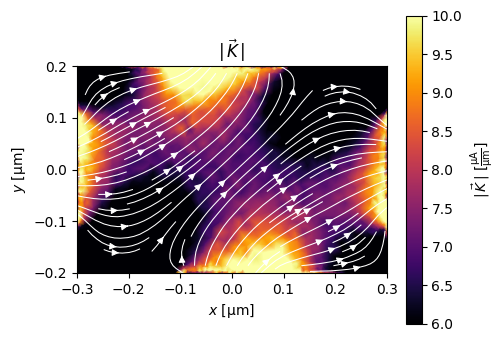

In [7]:
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=6, vmax=10)

In [8]:
if MAKE_ANIMATIONS:
    field_current_video = make_video_from_solution(
        zero_current_solution,
        quantities=["order_parameter", "phase"],
        figsize=(8, 4),
        vmax_a=[1,1],
        vmin_a=[0,-1],
        cmap_b=["gist_rainbow", "hsv"],
    )
    display(field_current_video,)

['gist_rainbow', 'hsv']
